In [11]:
import pandas as pd
import numpy as np 
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from tensorflow.keras import models,layers
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
from google.colab import auth
auth.authenticate_user()


project_id = 'fobo-722'
!gcloud config set project {project_id}

Updated property [core/project].


In [5]:
!gsutil cp gs://fobokiller-722/data/scrapping_cleaned.csv /tmp/scrapping_cleaned.csv

Copying gs://fobokiller-722/data/scrapping_cleaned.csv...
\ [1 files][ 45.7 MiB/ 45.7 MiB]                                                
Operation completed over 1 objects/45.7 MiB.                                     


In [76]:
#load data
df=pd.read_csv('/tmp/scrapping_cleaned.csv',index_col=0,nrows=10000)
X=df['review_clean']
y=df['rate']
#split train test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3)

In [78]:
y_test.unique()

array([5, 2, 1, 4, 3])

In [82]:
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [81]:
y_test_cat.shape

(3000, 6)

In [33]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

X_train = X_train.apply(text_to_word_sequence)
X_test = X_test.apply(text_to_word_sequence)

In [35]:
X_train

6902    [pleasant, evening, gem, restaurant, im, glad,...
8379    [even, start, exploring, area, near, arc, de, ...
5880    [tasty, big, portions, got, hot, cold, combo, ...
2174    [fantastic, bakery, great, breakfast, tables, ...
6351    [bit, hesitant, write, review, restaurant, one...
                              ...                        
7571    [excellent, food, get, beef, rolls, shrimp, pa...
6567    [dont, get, meat, barely, seasoned, sauce, sou...
2965    [yes, food, fantastic, cornish, game, hen, sau...
4431    [paris, u, must, bistrot, food, amazing, ones,...
5390    [delicious, local, place, nothing, pretentious...
Name: review_clean, Length: 7000, dtype: object

In [50]:
##init vectorizer
word2vec = Word2Vec(sentences=X_train, size=100, min_count=10, window=10)


In [37]:
# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])
        
    return np.array(embedded_sentence)

In [38]:
# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed

In [51]:
# Embed the training and test sentences
X_train_embed = embedding(word2vec, X_train)
X_test_embed = embedding(word2vec, X_test)

167

In [54]:
# Pad the training and test embedded sentences
X_train_pad = pad_sequences(X_train_embed, dtype='float32', padding='post', maxlen=200)
X_test_pad = pad_sequences(X_test_embed, dtype='float32', padding='post', maxlen=200)

In [55]:
X_train_pad.shape

(7000, 200, 100)

In [91]:
def init_model():
    model = models.Sequential()
    model.add(layers.Masking())
    model.add(layers.GRU(50, return_sequences=True, activation='tanh'))
    model.add(layers.GRU(40, activation='tanh'))
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dense(6, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model

model = init_model()

In [86]:
y_train_cat.shape

(7000, 6)

In [94]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(X_train_pad, y_train_cat, 
          batch_size = 16,
          epochs=100,
          validation_split=0.3,
          callbacks=[es]
         )

Epoch 1/100
307/307 [==============================] - 33s 69ms/step - loss: 1.3285 - accuracy: 0.4984 - val_loss: 1.3074 - val_accuracy: 0.5138
Epoch 2/100
307/307 [==============================] - 18s 59ms/step - loss: 1.3022 - accuracy: 0.5014 - val_loss: 1.2907 - val_accuracy: 0.5138
Epoch 3/100
307/307 [==============================] - 18s 59ms/step - loss: 1.2989 - accuracy: 0.5016 - val_loss: 1.3078 - val_accuracy: 0.5138
Epoch 4/100
307/307 [==============================] - 18s 59ms/step - loss: 1.2951 - accuracy: 0.5016 - val_loss: 1.2972 - val_accuracy: 0.5138
Epoch 5/100
307/307 [==============================] - 18s 59ms/step - loss: 1.2914 - accuracy: 0.5035 - val_loss: 1.3230 - val_accuracy: 0.5124
Epoch 6/100
307/307 [==============================] - 18s 59ms/step - loss: 1.2854 - accuracy: 0.5020 - val_loss: 1.2975 - val_accuracy: 0.5138
Epoch 7/100
307/307 [==============================] - 18s 59ms/step - loss: 1.2774 - accuracy: 0.5031 - val_loss: 1.3096 - val_ac

In [93]:
y_train.value_counts()/len(y_train)

5    0.505143
4    0.254429
3    0.097857
1    0.087143
2    0.055429
Name: rate, dtype: float64

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_loss_metrics(history, title=None):
    """
    used in DL to plot accuracy and metrics
    must be passed the history of the fitted model
    """
    # -- Retrieve metrics used
    metrics = []
    val_metrics = []

    for m in history.history.keys():
        if m.startswith('val_'):
            val_metrics.append(m)
        else:
            metrics.append(m)

    if len(metrics) % 2 != 0:
        row = len(metrics) // 2 + 1

    if len(metrics) % 2 == 0:
        row = len(metrics) // 2

    fig,axs = plt.subplots(row,2,figsize=(13, 4 * row))

    for m,ax in zip(metrics,axs.flat):
        ax.plot(history.history[m])
        ax.plot(history.history[f'val_{m}'])
        ax.set_title(f'Model {m}')
        ax.set_ylabel(f'{m}')
        ax.set_xlabel('Epoch')
        ax.legend(['Train', 'Test'], loc='best')
        ax.grid(axis="x", linewidth=0.5)
        ax.grid(axis="y", linewidth=0.5)

    if len(metrics) % 2 != 0:
        fig.delaxes[axs.flat[-1]]

    if title:
        fig.suptitle(title)

    pass

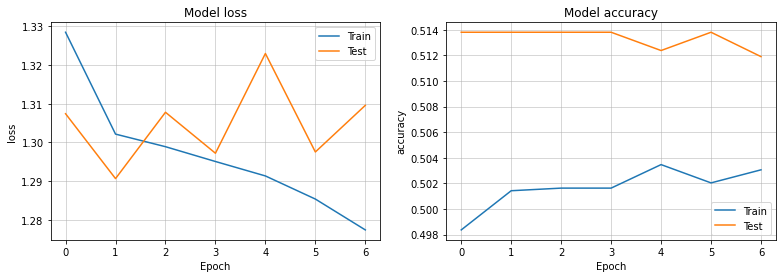

In [95]:
plot_loss_metrics(history)

In [99]:
## test with binary class 
y_train_binary=np.where(y_train<4,0,1)
np.unique(y_train_binary)

array([0, 1])

In [108]:
def init_model_binary():
    model = models.Sequential()
    model.add(layers.Masking())
    model.add(layers.GRU(50, return_sequences=True, activation='tanh'))
    model.add(layers.GRU(40, activation='tanh'))
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model

model_binary = init_model_binary()

Epoch 1/100
307/307 [==============================] - 33s 69ms/step - loss: 0.5608 - accuracy: 0.7578 - val_loss: 0.5497 - val_accuracy: 0.7624
Epoch 2/100
307/307 [==============================] - 18s 59ms/step - loss: 0.5549 - accuracy: 0.7584 - val_loss: 0.5504 - val_accuracy: 0.7624
Epoch 3/100
307/307 [==============================] - 18s 59ms/step - loss: 0.5540 - accuracy: 0.7584 - val_loss: 0.5502 - val_accuracy: 0.7624
Epoch 4/100
307/307 [==============================] - 18s 59ms/step - loss: 0.5525 - accuracy: 0.7584 - val_loss: 0.5627 - val_accuracy: 0.7610
Epoch 5/100
307/307 [==============================] - 18s 59ms/step - loss: 0.5502 - accuracy: 0.7588 - val_loss: 0.5506 - val_accuracy: 0.7624
Epoch 6/100
307/307 [==============================] - 18s 59ms/step - loss: 0.5483 - accuracy: 0.7586 - val_loss: 0.5588 - val_accuracy: 0.7624


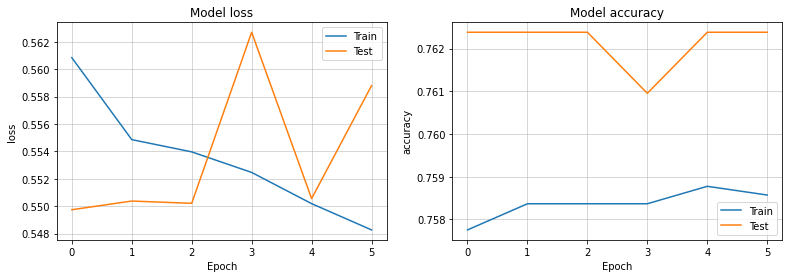

In [109]:
es = EarlyStopping(patience=5, restore_best_weights=True)

history_binary = model_binary.fit(X_train_pad, y_train_binary, 
          batch_size = 16,
          epochs=100,
          validation_split=0.3,
          callbacks=[es]
         )
plot_loss_metrics(history_binary)

In [111]:
np.unique(y_train_binary,return_counts=True)

(array([0, 1]), array([1683, 5317]))

In [112]:
5317/7000

0.7595714285714286